In [1]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string

# Introducing contact resistance between 2 tapes

- In this model we consider two tapes 1 m long divided in three sections.
- Electric field criterion for ngspice model is 100 microV/m

In [2]:
def readdata(filename):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)

    for line in src:
        #print line
        # Here we initialize the ngspice data array
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)


        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len (temp_list)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if line[0].isdigit():
            temp_data = [float(x) for x in line.split()]

            for c in range(n_columns):
                r = fill[c]
                #print(r, index [c])

                data [r][index[c]] = temp_data [c]

                fill [c] = fill [c] + 1
                if fill [c] == Data_points:
                    fill [c] = 0
    return data

In [3]:
# Fitting model including resistance 
def model_func(I,Rt,Ic,n):
    V0 = 10E-6 # Considering the criterion 100uV/m with length = 1 m
    return Rt*I+V0*(I/Ic)**n

def fit_exp(I,V,Rt0,Ic0,n0): #(Rt0,Ic0,n0) are guessed initial values 
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func, I, V,(Rt0,Ic0,n0))
    Rt,Ic,n = opt_parms
    return Rt,Ic,n

# Tapes divided in three sections: comparing short and open contact

<img src="3 sections.png">

In [4]:
# Definitions

# Function to generate netlist for ngspice
def generatenetlist(filename,Rc):
    Imax = 250
    Ic1 = 100
    Ic2 = 50
    Rt = 5E-7
    n = 30
    with open(filename, 'w') as output:
        output.write(f'* Netlist for 2 tapes with contact resistance\n') # Name of the circuit as a comment
        output.write('I1 0 N001 100\n') # Current source
        output.write(f'rt1 N002 N001 {Rt/2}\n')
        output.write(f'rt2 N006 N001 {Rt/2}\n')
        output.write(f'rt3 0 N005 {Rt/2}\n')
        output.write(f'rt4 N009 0 {Rt/2}\n')
        output.write(f'r1 N006 N002 {Rc}\n')
        output.write(f'r2 N007 N003 {Rc}\n')
        output.write(f'r3 N008 N004 {Rc}\n')
        output.write(f'r4 N009 N005 {Rc}\n')
        output.write(f'b1 N002 N003 V=33E-6*pow((I(b1)/{Ic1}),{n})\n')
        output.write(f'b2 N003 N004 V=33E-6*pow((I(b2)/{Ic1}),{n})\n')
        output.write(f'b3 N004 N005 V=33E-6*pow((I(b3)/{Ic1}),{n})\n')
        output.write(f'b4 N006 N007 V=33E-6*pow((I(b4)/{Ic2}),{n})\n')
        output.write(f'b5 N007 N008 V=33E-6*pow((I(b5)/{Ic2}),{n})\n')
        output.write(f'b6 N008 N009 V=33E-6*pow((I(b6)/{Ic2}),{n})\n')
        output.write('.options savecurrents\n')
        output.write(f'.dc I1 0 {Imax} 1\n')
        #output.write('.print dc  V(n001) I(B1)\n')
        #output.write('.print dc V(n001) @r1[i] @r2[i] @r3[i] @r4[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i]\n')
        output.write('.print dc v(n001) v(n002) v(n003) v(n004) v(n005) v(n006) v(n007) v(n008) v(n009) @r1[i] @r2[i] @r3[i] @r4[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i]\n')
        output.write('.end\n')

In [5]:
# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep']
num_resistances = 4
num_vsources = 6
num_nodes = 9
for i in range(num_nodes):
    Labels.append(f'v(n00{i+1})')
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')

    
print(Labels)
print(*Labels[2:], sep=' ')

['Index', 'i-sweep', 'v(n001)', 'v(n002)', 'v(n003)', 'v(n004)', 'v(n005)', 'v(n006)', 'v(n007)', 'v(n008)', 'v(n009)', '@r1[i]', '@r2[i]', '@r3[i]', '@r4[i]', '@b1[i]', '@b2[i]', '@b3[i]', '@b4[i]', '@b5[i]', '@b6[i]']
v(n001) v(n002) v(n003) v(n004) v(n005) v(n006) v(n007) v(n008) v(n009) @r1[i] @r2[i] @r3[i] @r4[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i]


In [6]:
'''
# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep','v(n001)']
num_resistances = 4
num_vsources = 6
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')
   
print(Labels)
#print(*Labels[2:], sep=' ')
'''
%matplotlib inline
sns.set_palette(sns.color_palette("hls", 12))

# Testing different values of contact resistance
Rc = np.array([1E-12,1000])

# Generating netlists and saving data
for i in range(len(Rc)):
    filename = f'Rc {Rc[i]}.cir'
    generatenetlist(filename,Rc[i])
    #Icable,Vt,IR1,IR2,IR3,IR4,IB1,IB2,IB3,IB4,IB5,IB6 = gettingdata(filename)
    if i == 0:
        data1 = readdata(filename)
        #print('data1')
        #print(data1)
    if i == 1:
        data2 = readdata(filename)
        #print('data2')
        #print(data2)

'''
# Plotting data for two cases
Icable1 = data1[:,1]
Icable2 = data2[:,1]

plt.plot(Icable1,data1[:,2],label = Labels[2]+f' Rc {Rc[0]}')
plt.plot(Icable2,data2[:,2],'--',label = Labels[2]+f' Rc {Rc[1]}')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage')
plt.ylim(0,100E-6)
plt.xlim(0,150)
plt.grid()
plt.legend()
plt.show()

nc = 11
for i in range(num_resistances):
    plt.plot(Icable1,data1[:,i+nc],label = Labels[i+nc]+f' Rc {Rc[0]}')
    plt.plot(Icable2,data2[:,i+nc],'--',label = Labels[i+nc]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through contact resistances Rc')
plt.xlim(0,150)
plt.grid()
plt.legend()
plt.show()

nc2 = 15
for i in range(num_vsources):
    plt.plot(Icable1,data1[:,i+nc2],label = Labels[i+nc2]+f' Rc {Rc[0]}')
    plt.plot(Icable2,data2[:,i+nc2],'--',label = Labels[i+nc2]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through SC voltage sources')
plt.xlim(0,150)
plt.grid()
plt.legend()
plt.show()
'''

"\n# Plotting data for two cases\nIcable1 = data1[:,1]\nIcable2 = data2[:,1]\n\nplt.plot(Icable1,data1[:,2],label = Labels[2]+f' Rc {Rc[0]}')\nplt.plot(Icable2,data2[:,2],'--',label = Labels[2]+f' Rc {Rc[1]}')\nplt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))\nplt.xlabel('I_cable (A)')\nplt.ylabel('Voltage (V)')\nplt.title('Terminal voltage')\nplt.ylim(0,100E-6)\nplt.xlim(0,150)\nplt.grid()\nplt.legend()\nplt.show()\n\nnc = 11\nfor i in range(num_resistances):\n    plt.plot(Icable1,data1[:,i+nc],label = Labels[i+nc]+f' Rc {Rc[0]}')\n    plt.plot(Icable2,data2[:,i+nc],'--',label = Labels[i+nc]+f' Rc {Rc[1]}')\nplt.xlabel('I_cable (A)')\nplt.ylabel('Current (A)')\nplt.title('Current through contact resistances Rc')\nplt.xlim(0,150)\nplt.grid()\nplt.legend()\nplt.show()\n\nnc2 = 15\nfor i in range(num_vsources):\n    plt.plot(Icable1,data1[:,i+nc2],label = Labels[i+nc2]+f' Rc {Rc[0]}')\n    plt.plot(Icable2,data2[:,i+nc2],'--',label = Labels[i+nc2]+f' Rc {Rc[1]}')\nplt.xlabel(

<IPython.core.display.Javascript object>


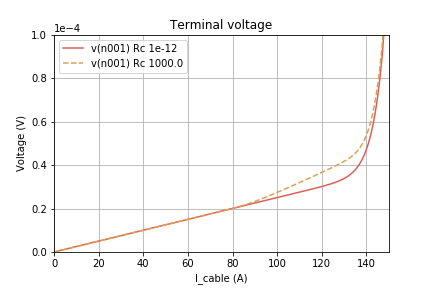

In [7]:
%matplotlib notebook

# Plotting data for two cases
Icable1 = data1[:,1]
Icable2 = data2[:,1]


plt.plot(Icable1,data1[:,2],label = Labels[2]+f' Rc {Rc[0]}')
plt.plot(Icable2,data2[:,2],'--',label = Labels[2]+f' Rc {Rc[1]}')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage')
plt.ylim(0,100E-6)
plt.xlim(0,150)
plt.grid()
plt.legend()

<IPython.core.display.Javascript object>


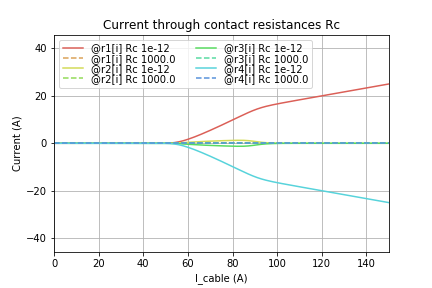

In [11]:
%matplotlib notebook
nc = 11
for i in range(num_resistances):
    plt.plot(Icable1,data1[:,i+nc],label = Labels[i+nc]+f' Rc {Rc[0]}')
    plt.plot(Icable2,data2[:,i+nc],'--',label = Labels[i+nc]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through contact resistances Rc')
plt.xlim(0,150)
plt.grid()
plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


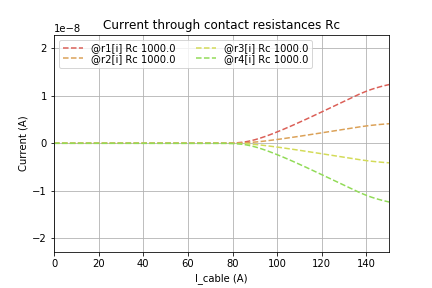

In [13]:
# Zoom in
%matplotlib notebook
nc = 11
for i in range(num_resistances):
    #plt.plot(Icable1,data1[:,i+nc],label = Labels[i+nc]+f' Rc {Rc[0]}')
    plt.plot(Icable2,data2[:,i+nc],'--',label = Labels[i+nc]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through contact resistances Rc')
plt.xlim(0,150)
plt.grid()
plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


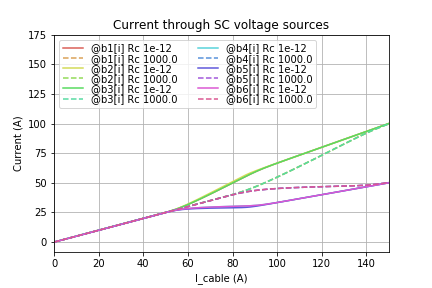

In [16]:

sns.set_palette(sns.color_palette("hls", 12))
%matplotlib notebook
nc2 = 15
for i in range(num_vsources):
    plt.plot(Icable1,data1[:,i+nc2],label = Labels[i+nc2]+f' Rc {Rc[0]}')
    plt.plot(Icable2,data2[:,i+nc2],'--',label = Labels[i+nc2]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through SC voltage sources')
plt.xlim(0,150)
plt.grid()
plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
plt.show()




<IPython.core.display.Javascript object>


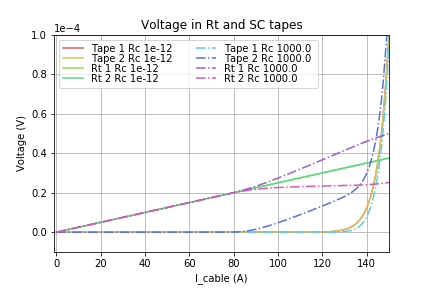

In [17]:
%matplotlib notebook
sns.set_palette(sns.color_palette("hls", 8))
# Voltage through tapes and terminal resistances

# Case of short circuit (low Rc)
SP1_s = data1[:,3]-data1[:,6]
SP2_s = data1[:,7]-data1[:,10]
Rt1_s = (data1[:,2]-data1[:,3])+(data1[:,6])
Rt2_s = (data1[:,2]-data1[:,7])+(data1[:,10])

# Case of open circuit (high Rc)
SP1_o = data2[:,3]-data2[:,6]
SP2_o = data2[:,7]-data2[:,10]
Rt1_o = (data2[:,2]-data2[:,3])+(data2[:,6])
Rt2_o = (data2[:,2]-data2[:,7])+(data2[:,10])


plt.plot(Icable1,SP1_s,label=f'Tape 1 Rc {Rc[0]} ')
plt.plot(Icable1,SP2_s,label=f'Tape 2 Rc {Rc[0]} ')
plt.plot(Icable1,Rt1_s,label=f'Rt 1 Rc {Rc[0]} ')
plt.plot(Icable1,Rt2_s,label=f'Rt 2 Rc {Rc[0]} ')



plt.plot(Icable2,SP1_o,'-.',label=f'Tape 1 Rc {Rc[1]} ')
plt.plot(Icable2,SP2_o,'-.',label=f'Tape 2 Rc {Rc[1]} ')
plt.plot(Icable2,Rt1_o,'-.',label=f'Rt 1 Rc {Rc[1]} ')
plt.plot(Icable2,Rt2_o,'-.',label=f'Rt 2 Rc {Rc[1]} ')

plt.ylim(-1e-5,100e-6)
plt.xlim(-1,150)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Voltage in Rt and SC tapes')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.legend(labelspacing=0.01,ncol=2,loc='upper left')
plt.grid()

<IPython.core.display.Javascript object>


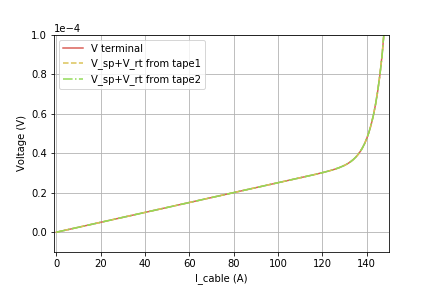

In [18]:
# Checking if the values are correct for low contact resistance
%matplotlib notebook
plt.plot(Icable1,data1[:,2],label = 'V terminal')
vadd = SP1_s+Rt1_s
plt.plot(Icable1,vadd,'--',label = 'V_sp+V_rt from tape1')
vadd = SP2_s+Rt2_s
plt.plot(Icable1,vadd,'-.',label = 'V_sp+V_rt from tape2')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(-1e-5,100e-6)
plt.xlim(-1,150)
plt.legend()
plt.grid()


2.499992245629716e-07 139.05640488552078 30.035572588340347
Fit: Rt = 2.499992245629716e-07, Ic = 139.05640488552078, n = 30.035572588340347, Fit-error = 1.4658811696383582e-09


<IPython.core.display.Javascript object>


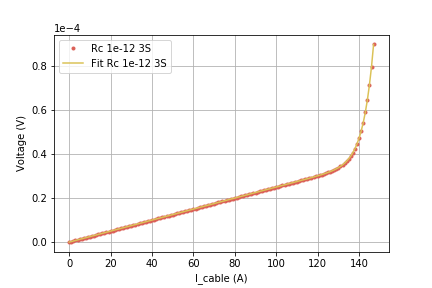

In [19]:
# Fitting for short circuit case

%matplotlib notebook

Vt1 = data1[:,2]
#plt.plot(Icable1,label = 'V terminal')

Vt_lim = []
Icable_lim = []
# Voltage limit
for l in range(len(Vt1)):
    if Vt1[l] <= 100e-6: # Limit of the total voltage
        Vt_lim.append(Vt1[l])
        Icable_lim.append(Icable1[l])

Vt_lim = np.array(Vt_lim)
Icable_lim = np.array(Icable_lim)
    
# Exponential fitting
Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
print(Rt_e,Ic_e,n_e)
    
# Getting curve from fitting 
Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

# Calculating fitting error
Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
# Plotting
print(f'Fit: Rt = {Rt_e}, Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
plt.plot(Icable_lim,Vt_lim,'.',label = f'Rc {Rc[0]} 3S')
plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {Rc[0]} 3S')

plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()

2.7487459002698234e-07 136.32578908678022 21.391291850535644
Fit: Rt = 2.7487459002698234e-07, Ic = 136.32578908678022, n = 21.391291850535644, Fit-error = 1.9229836757141517e-05


<IPython.core.display.Javascript object>


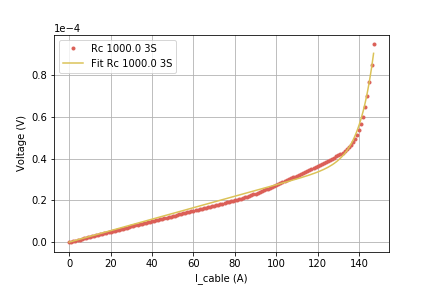

In [20]:
# Fitting for open circuit case

%matplotlib notebook

Vt2 = data2[:,2]
#plt.plot(Icable1,label = 'V terminal')

Vt_lim = []
Icable_lim = []
# Voltage limit
for l in range(len(Vt2)):
    if Vt2[l] <= 100e-6: # Limit of the total voltage
        Vt_lim.append(Vt2[l])
        Icable_lim.append(Icable2[l])

Vt_lim = np.array(Vt_lim)
Icable_lim = np.array(Icable_lim)
    
# Exponential fitting
Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
print(Rt_e,Ic_e,n_e)
    
# Getting curve from fitting 
Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

# Calculating fitting error
Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
# Plotting
print(f'Fit: Rt = {Rt_e}, Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
plt.plot(Icable_lim,Vt_lim,'.',label = f'Rc {Rc[1]} 3S')
plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {Rc[1]} 3S')

plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()

# Tape considering only one section

<img src="1 section.png">

In [21]:
# Function to generate netlist for ngspice
def generatenetlist_onesection(filename,Rc):
    Imax = 250
    Ic1 = 100
    Ic2 = 50
    Rt = 5E-7
    n = 30
    with open(filename, 'w') as output:
        output.write(f'* Netlist for 2 tapes with contact resistance\n') # Name of the circuit as a comment
        output.write('I1 0 N001 100\n') # Current source
        output.write(f'rt_i_1 N002 N001 {Rt/2}\n')
        output.write(f'rt_i_2 N004 N001 {Rt/2}\n')
        output.write(f'rt_f_1 0 N003 {Rt/2}\n')
        output.write(f'rt_f_2 0 N005 {Rt/2}\n')
        output.write(f'r1 N004 N002 {Rc}\n')
        output.write(f'r2 N005 N003 {Rc}\n')
        output.write(f'b1 N002 N003 V=100E-6*pow((I(b1)/{Ic1}),{n})\n')
        output.write(f'b2 N004 N005 V=100E-6*pow((I(b2)/{Ic2}),{n})\n')
        output.write('.options savecurrents\n')
        output.write(f'.dc I1 0 {Imax} 1\n')
        #output.write('.print dc  V(n001) I(B1)\n')
        #output.write('.print dc V(n001) @r1[i] @r2[i] @r3[i] @r4[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i]\n')
        output.write('.print dc v(n001) v(n002) v(n003) v(n004) v(n005) @r1[i] @r2[i] @b1[i] @b2[i]\n')
        output.write('.end\n')
        
        

In [22]:
# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep']
num_resistances = 2
num_vsources = 2
num_nodes = 5
for i in range(num_nodes):
    Labels.append(f'v(n00{i+1})')
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')
    
print(Labels)
print(*Labels[2:], sep=' ')

['Index', 'i-sweep', 'v(n001)', 'v(n002)', 'v(n003)', 'v(n004)', 'v(n005)', '@r1[i]', '@r2[i]', '@b1[i]', '@b2[i]']
v(n001) v(n002) v(n003) v(n004) v(n005) @r1[i] @r2[i] @b1[i] @b2[i]


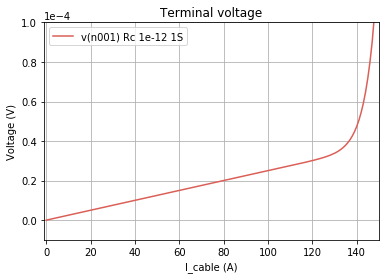

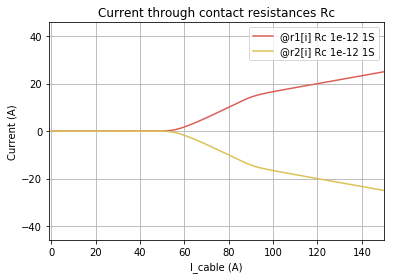

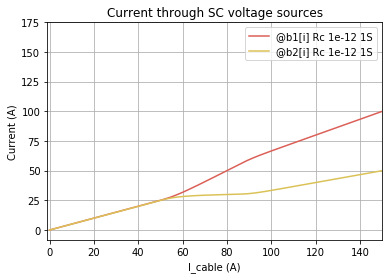

In [23]:
%matplotlib inline

'''
# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep','v(n001)']
num_resistances = 2
num_vsources = 2
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')
    
print(Labels)
#print(*Labels[2:], sep=' ')
'''

# Testing different values of contact resistance
Rc = np.array([1E-12])

# Generating netlists and saving data
for i in range(len(Rc)):
    filename = f'1s-Rc {Rc[i]}.cir'
    generatenetlist_onesection(filename,Rc[i])
    #Icable,Vt,IR1,IR2,IR3,IR4,IB1,IB2,IB3,IB4,IB5,IB6 = gettingdata(filename)
    if i == 0:
        data1S = readdata(filename)
        #print('data1')
        #print(data1)
        
#data2 = readdata(f'Rc {Rc[0]}.cir')



# Plotting data for two cases
Icable1S = data1S[:,1]
#Icable2 = data2[:,1]

plt.plot(Icable1S,data1S[:,2],label = Labels[2]+f' Rc {Rc[0]} 1S')
#plt.plot(Icable2,data2[:,2],'--',label = Labels2[2]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(-1e-5,100e-6)
plt.xlim(-1,150)
plt.grid()
plt.legend()
plt.show()

nc = 7
for i in range(num_resistances):
    plt.plot(Icable1S,data1S[:,i+nc],label = Labels[i+nc]+f' Rc {Rc[0]} 1S')
    #plt.plot(Icable2,data2[:,i+3],'--',label = Labels2[i+3]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through contact resistances Rc')
plt.xlim(-1,150)
plt.grid()
plt.legend()
plt.show()

nc2 = 9
for i in range(num_vsources):
    plt.plot(Icable1S,data1S[:,i+nc2],label = Labels[i+nc2]+f' Rc {Rc[0]} 1S')
    #plt.plot(Icable2,data2[:,i+7],'--',label = Labels[i+7]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through SC voltage sources')
plt.xlim(-1,150)
plt.grid()
plt.legend()
plt.show()



<IPython.core.display.Javascript object>


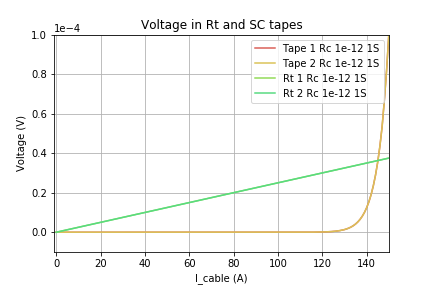

In [24]:
%matplotlib notebook
# Voltage through tapes and terminal resistances

# Case of short circuit (low Rc)
SP1_s1 = data1S[:,3]-data1S[:,4]
SP2_s1 = data1S[:,5]-data1S[:,6]
Rt1_s1 = (data1S[:,2]-data1S[:,3])+(data1S[:,4])
Rt2_s1 = (data1S[:,2]-data1S[:,5])+(data1S[:,6])


plt.plot(Icable1S,SP1_s1,label=f'Tape 1 Rc {Rc[0]} 1S')
plt.plot(Icable1S,SP2_s1,label=f'Tape 2 Rc {Rc[0]} 1S')
plt.plot(Icable1S,Rt1_s1,label=f'Rt 1 Rc {Rc[0]} 1S')
plt.plot(Icable1S,Rt2_s1,label=f'Rt 2 Rc {Rc[0]} 1S')


plt.ylim(-1e-5,100e-6)
plt.xlim(-1,150)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Voltage in Rt and SC tapes')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()

2.4999921983277793e-07 139.00988318152181 30.035576910224805
Fit: Rt = 2.4999921983277793e-07, Ic = 139.00988318152181, n = 30.035576910224805, Fit-error = 1.482490879629494e-09


<IPython.core.display.Javascript object>


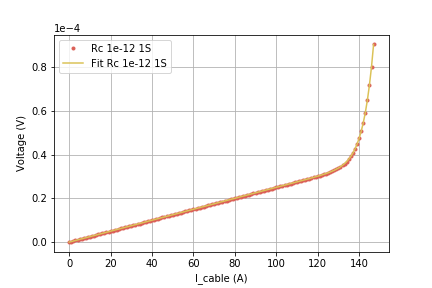

In [25]:
# Fitting exponential 

%matplotlib notebook
Vt1S = data1S[:,2]

Vt_lim = []
Icable_lim = []
# Voltage limit
for l in range(len(Vt1S)):
    if Vt1S[l] <= 100e-6: # Limit of the total voltage
        Vt_lim.append(Vt1S[l])
        Icable_lim.append(Icable1S[l])

Vt_lim = np.array(Vt_lim)
Icable_lim = np.array(Icable_lim)
    
# Exponential fitting
Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
print(Rt_e,Ic_e,n_e)
    
# Getting curve from fitting 
Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

# Calculating fitting error
Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
# Plotting
print(f'Fit: Rt = {Rt_e}, Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
plt.plot(Icable_lim,Vt_lim,'.',label = f'Rc {Rc[0]} 1S')
plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {Rc[0]} 1S')

plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()




# Tape considering 5 sections

<img src="5 sections.png">

In [26]:
# Function to generate netlist for ngspice
def generatenetlist_fivesection(filename,Rc):
    Imax = 250
    Ic1 = 100
    Ic2 = 50
    Rt = 5E-7
    n = 30
    with open(filename, 'w') as output:
        output.write(f'* Netlist for 2 tapes with contact resistance\n') # Name of the circuit as a comment
        output.write('I1 0 N001 100\n') # Current source
        output.write(f'rt1 N002 N001 {Rt/2}\n')
        output.write(f'rt2 0 N007 {Rt/2}\n')
        output.write(f'rt3 N008 N001 {Rt/2}\n')
        output.write(f'rt4 N013 0 {Rt/2}\n')
        output.write(f'r1 N008 N002 {Rc}\n')
        output.write(f'r2 N009 N003 {Rc}\n')
        output.write(f'r3 N010 N004 {Rc}\n')
        output.write(f'r4 N011 N005 {Rc}\n')
        output.write(f'r5 N012 N006 {Rc}\n')
        output.write(f'r6 N013 N007 {Rc}\n')
        output.write(f'b1 N002 N003 V=20E-6*pow((I(b1)/{Ic1}),{n})\n')
        output.write(f'b2 N003 N004 V=20E-6*pow((I(b2)/{Ic1}),{n})\n')
        output.write(f'b3 N004 N005 V=20E-6*pow((I(b3)/{Ic1}),{n})\n')
        output.write(f'b4 N005 N006 V=20E-6*pow((I(b4)/{Ic1}),{n})\n')
        output.write(f'b5 N006 N007 V=20E-6*pow((I(b5)/{Ic1}),{n})\n')
        output.write(f'b6 N008 N009 V=20E-6*pow((I(b6)/{Ic2}),{n})\n')
        output.write(f'b7 N009 N010 V=20E-6*pow((I(b7)/{Ic2}),{n})\n')
        output.write(f'b8 N010 N011 V=20E-6*pow((I(b8)/{Ic2}),{n})\n')
        output.write(f'b9 N011 N012 V=20E-6*pow((I(b9)/{Ic2}),{n})\n')
        output.write(f'b10 N012 N013 V=20E-6*pow((I(b10)/{Ic2}),{n})\n')
        output.write('.options savecurrents\n')
        output.write(f'.dc I1 0 {Imax} 1\n')
        #output.write('.print dc  V(n001) I(B1)\n')
        #output.write('.print dc V(n001) @r1[i] @r2[i] @r3[i] @r4[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i]\n')
        output.write('.print dc v(n001) v(n002) v(n003) v(n004) v(n005) v(n006) v(n007) v(n008) v(n009) v(n010) v(n011) v(n012) v(n013) @r1[i] @r2[i] @r3[i] @r4[i] @r5[i] @r6[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i] @b7[i] @b8[i] @b9[i] @b10[i]\n')
        output.write('.end\n')

In [27]:
# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep']
num_sections = 5
num_resistances = num_sections+1
num_vsources = num_sections*2
num_nodes = ((num_sections+1)*2)+1
for i in range(num_nodes):
    if i<9:
        Labels.append(f'v(n00{i+1})')
    else:
        Labels.append(f'v(n0{i+1})')
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')
    
print(Labels)
print(*Labels[2:], sep=' ')

['Index', 'i-sweep', 'v(n001)', 'v(n002)', 'v(n003)', 'v(n004)', 'v(n005)', 'v(n006)', 'v(n007)', 'v(n008)', 'v(n009)', 'v(n010)', 'v(n011)', 'v(n012)', 'v(n013)', '@r1[i]', '@r2[i]', '@r3[i]', '@r4[i]', '@r5[i]', '@r6[i]', '@b1[i]', '@b2[i]', '@b3[i]', '@b4[i]', '@b5[i]', '@b6[i]', '@b7[i]', '@b8[i]', '@b9[i]', '@b10[i]']
v(n001) v(n002) v(n003) v(n004) v(n005) v(n006) v(n007) v(n008) v(n009) v(n010) v(n011) v(n012) v(n013) @r1[i] @r2[i] @r3[i] @r4[i] @r5[i] @r6[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i] @b7[i] @b8[i] @b9[i] @b10[i]


# Case of short circuit

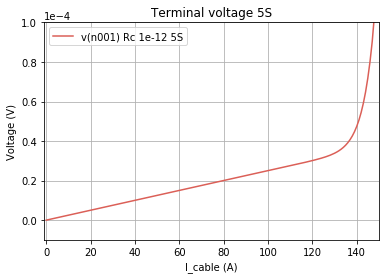

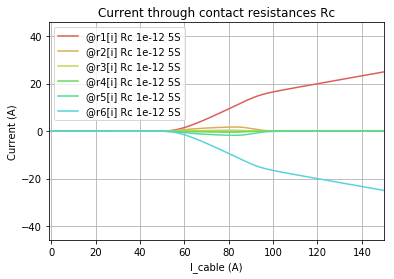

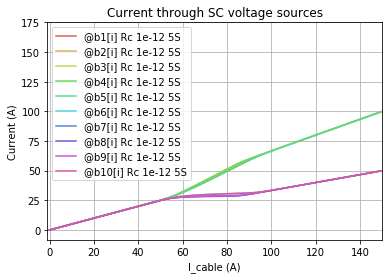

In [29]:
%matplotlib inline

sns.set_palette(sns.color_palette("hls", 10))
'''
# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep','v(n001)']
num_resistances = 2
num_vsources = 2
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')
    
print(Labels)
#print(*Labels[2:], sep=' ')
'''

# Testing different values of contact resistance
Rc = np.array([1E-12])

# Generating netlists and saving data
for i in range(len(Rc)):
    filename = f'5s-Rc {Rc[i]}.cir'
    generatenetlist_fivesection(filename,Rc[i])
    #Icable,Vt,IR1,IR2,IR3,IR4,IB1,IB2,IB3,IB4,IB5,IB6 = gettingdata(filename)
    if i == 0:
        data5S = readdata(filename)
        #print('data1')
        #print(data5S)
        
#data2 = readdata(f'Rc {Rc[0]}.cir')



# Plotting data for two cases
Icable5S = data5S[:,1]
#Icable2 = data2[:,1]

plt.plot(Icable5S,data5S[:,2],label = Labels[2]+f' Rc {Rc[0]} 5S')
#plt.plot(Icable2,data2[:,2],'--',label = Labels2[2]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage 5S')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(-1e-5,100e-6)
plt.xlim(-1,150)
plt.grid()
plt.legend()
plt.show()

nc = 15
for i in range(num_resistances):
    plt.plot(Icable5S,data5S[:,i+nc],label = Labels[i+nc]+f' Rc {Rc[0]} 5S')
    #plt.plot(Icable2,data2[:,i+3],'--',label = Labels2[i+3]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through contact resistances Rc')
plt.xlim(-1,150)
plt.grid()
plt.legend()
plt.show()

nc2 = 21
for i in range(num_vsources):
    plt.plot(Icable5S,data5S[:,i+nc2],label = Labels[i+nc2]+f' Rc {Rc[0]} 5S')
    #plt.plot(Icable2,data2[:,i+7],'--',label = Labels[i+7]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through SC voltage sources')
plt.xlim(-1,150)
plt.grid()
plt.legend()
plt.show()




<IPython.core.display.Javascript object>


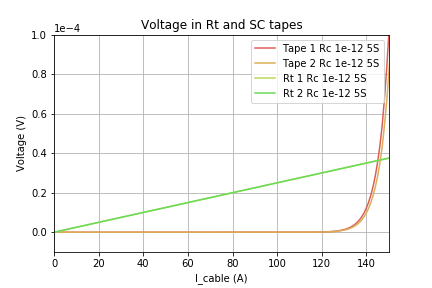

In [31]:
%matplotlib notebook
# Voltage through tapes and terminal resistances

# Case of short circuit (low Rc)
SP1_s5 = data5S[:,3]-data5S[:,8]
SP2_s5 = data5S[:,9]-data5S[:,13]
Rt1_s5 = (data5S[:,2]-data5S[:,3])+(data5S[:,8])
Rt2_s5 = (data5S[:,2]-data5S[:,9])+(data5S[:,14])


plt.plot(Icable5S,SP1_s5,label=f'Tape 1 Rc {Rc[0]} 5S')
plt.plot(Icable5S,SP2_s5,label=f'Tape 2 Rc {Rc[0]} 5S')
plt.plot(Icable5S,Rt1_s5,label=f'Rt 1 Rc {Rc[0]} 5S')
plt.plot(Icable5S,Rt2_s5,label=f'Rt 2 Rc {Rc[0]} 5S')


plt.ylim(-1e-5,100e-6)
plt.xlim(0,150)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Voltage in Rt and SC tapes')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()

2.499992201794658e-07 139.00988320731025 30.035577002094996
Fit: Rt = 2.499992201794658e-07, Ic = 139.00988320731025, n = 30.035577002094996, Fit-error = 1.4826306810622548e-09


<IPython.core.display.Javascript object>


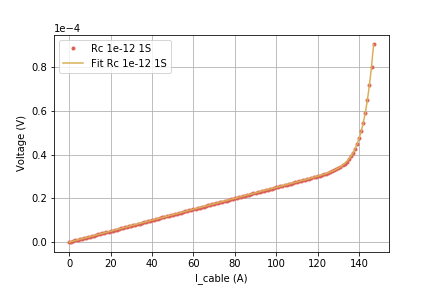

In [32]:
# Fitting exponential 

%matplotlib notebook
Vt5S = data5S[:,2]

Vt_lim = []
Icable_lim = []
# Voltage limit
for l in range(len(Vt5S)):
    if Vt5S[l] <= 100e-6: # Limit of the total voltage
        Vt_lim.append(Vt5S[l])
        Icable_lim.append(Icable5S[l])

Vt_lim = np.array(Vt_lim)
Icable_lim = np.array(Icable_lim)
    
# Exponential fitting
Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
print(Rt_e,Ic_e,n_e)
    
# Getting curve from fitting 
Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

# Calculating fitting error
Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
# Plotting
print(f'Fit: Rt = {Rt_e}, Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
plt.plot(Icable_lim,Vt_lim,'.',label = f'Rc {Rc[0]} 1S')
plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {Rc[0]} 1S')

plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()



# Case of open circuit

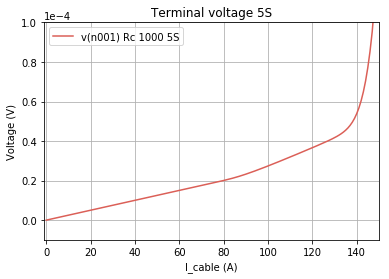

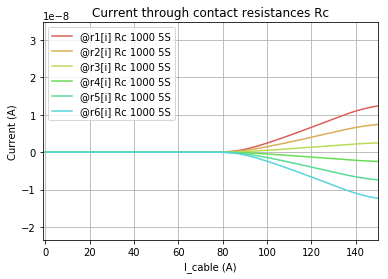

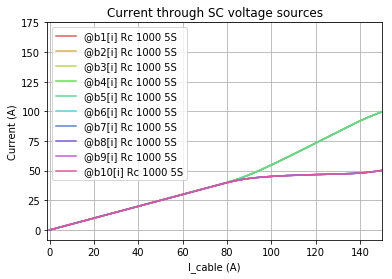

In [33]:
%matplotlib inline


# Testing different values of contact resistance
Rc = np.array([1000])

# Generating netlists and saving data
for i in range(len(Rc)):
    filename = f'5s-Rc {Rc[i]}.cir'
    generatenetlist_fivesection(filename,Rc[i])
    #Icable,Vt,IR1,IR2,IR3,IR4,IB1,IB2,IB3,IB4,IB5,IB6 = gettingdata(filename)
    if i == 0:
        data5S = readdata(filename)
        #print('data1')
        #print(data5S)
        
#data2 = readdata(f'Rc {Rc[0]}.cir')



# Plotting data for two cases
Icable5S = data5S[:,1]
#Icable2 = data2[:,1]

plt.plot(Icable5S,data5S[:,2],label = Labels[2]+f' Rc {Rc[0]} 5S')
#plt.plot(Icable2,data2[:,2],'--',label = Labels2[2]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage 5S')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(-1e-5,100e-6)
plt.xlim(-1,150)
plt.grid()
plt.legend()
plt.show()

nc = 15
for i in range(num_resistances):
    plt.plot(Icable5S,data5S[:,i+nc],label = Labels[i+nc]+f' Rc {Rc[0]} 5S')
    #plt.plot(Icable2,data2[:,i+3],'--',label = Labels2[i+3]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through contact resistances Rc')
plt.xlim(-1,150)
plt.grid()
plt.legend()
plt.show()

nc2 = 21
for i in range(num_vsources):
    plt.plot(Icable5S,data5S[:,i+nc2],label = Labels[i+nc2]+f' Rc {Rc[0]} 5S')
    #plt.plot(Icable2,data2[:,i+7],'--',label = Labels[i+7]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through SC voltage sources')
plt.xlim(-1,150)
plt.grid()
plt.legend()
plt.show()




<IPython.core.display.Javascript object>


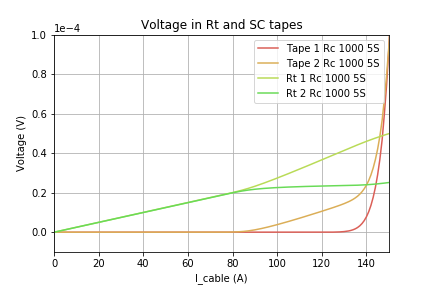

In [34]:
%matplotlib notebook
# Voltage through tapes and terminal resistances

# Case of short circuit (low Rc)
SP1_s5 = data5S[:,3]-data5S[:,8]
SP2_s5 = data5S[:,9]-data5S[:,13]
Rt1_s5 = (data5S[:,2]-data5S[:,3])+(data5S[:,8])
Rt2_s5 = (data5S[:,2]-data5S[:,9])+(data5S[:,14])


plt.plot(Icable5S,SP1_s5,label=f'Tape 1 Rc {Rc[0]} 5S')
plt.plot(Icable5S,SP2_s5,label=f'Tape 2 Rc {Rc[0]} 5S')
plt.plot(Icable5S,Rt1_s5,label=f'Rt 1 Rc {Rc[0]} 5S')
plt.plot(Icable5S,Rt2_s5,label=f'Rt 2 Rc {Rc[0]} 5S')


plt.ylim(-1e-5,100e-6)
plt.xlim(0,150)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Voltage in Rt and SC tapes')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid()

2.7499230071436793e-07 136.32205876663423 21.52692869057121
Fit: Rt = 2.7499230071436793e-07, Ic = 136.32205876663423, n = 21.52692869057121, Fit-error = 1.9266501937271713e-05


<IPython.core.display.Javascript object>


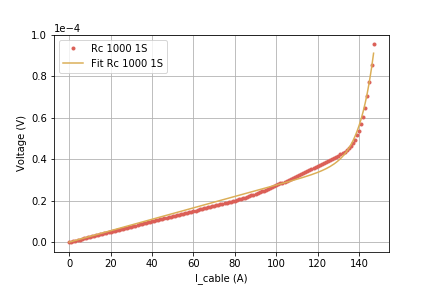

In [35]:
# Fitting exponential 

%matplotlib notebook
Vt5S = data5S[:,2]

Vt_lim = []
Icable_lim = []
# Voltage limit
for l in range(len(Vt5S)):
    if Vt5S[l] <= 100e-6: # Limit of the total voltage
        Vt_lim.append(Vt5S[l])
        Icable_lim.append(Icable5S[l])

Vt_lim = np.array(Vt_lim)
Icable_lim = np.array(Icable_lim)
    
# Exponential fitting
Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
print(Rt_e,Ic_e,n_e)
    
# Getting curve from fitting 
Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

# Calculating fitting error
Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))
    
# Plotting
print(f'Fit: Rt = {Rt_e}, Ic = {Ic_e}, n = {n_e}, Fit-error = {Error}')
plt.plot(Icable_lim,Vt_lim,'.',label = f'Rc {Rc[0]} 1S')
plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rc {Rc[0]} 1S')

plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.grid()




# Comparing all cases

In [ ]:
%matplotlib notebook 

# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep','v(n001)']
num_resistances = 4
num_vsources = 6
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')
    
print(Labels)
#print(*Labels[2:], sep=' ')


# Testing different values of contact resistance
Rc = np.array([1E-12,1000])

# Generating netlists and saving data
for i in range(len(Rc)):
    filename = f'Rc {Rc[i]}.cir'
    generatenetlist(filename,Rc[i])
    #Icable,Vt,IR1,IR2,IR3,IR4,IB1,IB2,IB3,IB4,IB5,IB6 = gettingdata(filename)
    if i == 0:
        data1 = readdata(filename)
        #print('data1')
        #print(data1)
    if i == 1:
        data2 = readdata(filename)
        #print('data2')
        #print(data2)

# Plotting data for two cases
Icable1 = data1[:,1]
Icable2 = data2[:,1]

plt.plot(Icable1,data1[:,2],label = Labels[2]+f' Rc {Rc[0]}')
plt.plot(Icable2,data2[:,2],'--',label = Labels[2]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage')
plt.legend()
plt.show()

# one section
# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep']
num_resistances = 2
num_vsources = 2
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')
    
print(Labels)
#print(*Labels[2:], sep=' ')


# Testing different values of contact resistance
Rc = np.array([1E-12])

# Generating netlists and saving data
for i in range(len(Rc)):
    filename = f'1s-Rc {Rc[i]}.cir'
    generatenetlist_onesection(filename,Rc[i])
    #Icable,Vt,IR1,IR2,IR3,IR4,IB1,IB2,IB3,IB4,IB5,IB6 = gettingdata(filename)
    if i == 0:
        data1 = readdata(filename)
        #print('data1')
        
# Plotting data for two cases
Icable1 = data1[:,1]
#Icable2 = data2[:,1]

plt.plot(Icable1,data1[:,2],'k--',label = Labels[2]+f' Rc {Rc[0]} 1S')
#plt.plot(Icable2,data2[:,2],'--',label = Labels2[2]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(0,1E-4)
plt.legend()
plt.show()

In [ ]:
%matplotlib notebook 

# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep','v(n001)']
num_resistances = 4
num_vsources = 6
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')
    
print(Labels)
#print(*Labels[2:], sep=' ')


# Testing different values of contact resistance
Rc = np.array([1E-12,1000])

# Generating netlists and saving data
for i in range(len(Rc)):
    filename = f'Rc {Rc[i]}.cir'
    generatenetlist(filename,Rc[i])
    #Icable,Vt,IR1,IR2,IR3,IR4,IB1,IB2,IB3,IB4,IB5,IB6 = gettingdata(filename)
    if i == 0:
        data1 = readdata(filename)
        #print('data1')
        #print(data1)
    if i == 1:
        data2 = readdata(filename)
        #print('data2')
        #print(data2)

# Plotting data for two cases
Icable1 = data1[:,1]
Icable2 = data2[:,1]

for i in range(num_resistances):
    plt.plot(Icable1,data1[:,i+3],label = Labels[i+3]+f' Rc {Rc[0]}')
    plt.plot(Icable2,data2[:,i+3],'--',label = Labels[i+3]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through contact resistances Rc')
plt.legend()
plt.show()

# one section
# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep','v(n001)']
num_resistances = 2
num_vsources = 2
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')
    
print(Labels)
#print(*Labels[2:], sep=' ')


# Testing different values of contact resistance
Rc = np.array([1E-12])

# Generating netlists and saving data
for i in range(len(Rc)):
    filename = f'1s-Rc {Rc[i]}.cir'
    generatenetlist_onesection(filename,Rc[i])
    #Icable,Vt,IR1,IR2,IR3,IR4,IB1,IB2,IB3,IB4,IB5,IB6 = gettingdata(filename)
    if i == 0:
        data1 = readdata(filename)
        #print('data1')
        
# Plotting data for two cases
Icable1 = data1[:,1]
#Icable2 = data2[:,1]

for i in range(num_resistances):
    plt.plot(Icable1,data1[:,i+3],'-.',label = Labels[i+3]+f' Rc {Rc[0]} 1S')
    #plt.plot(Icable2,data2[:,i+3],'--',label = Labels2[i+3]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.xlim(0,150)
plt.legend()
plt.show()

In [ ]:
sns.set_palette(sns.color_palette("hls", 12))

%matplotlib notebook 

# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep','v(n001)']
num_resistances = 4
num_vsources = 6
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')
    
print(Labels)
#print(*Labels[2:], sep=' ')


# Testing different values of contact resistance
Rc = np.array([1E-12,1000])

# Generating netlists and saving data
for i in range(len(Rc)):
    filename = f'Rc {Rc[i]}.cir'
    generatenetlist(filename,Rc[i])
    #Icable,Vt,IR1,IR2,IR3,IR4,IB1,IB2,IB3,IB4,IB5,IB6 = gettingdata(filename)
    if i == 0:
        data1 = readdata(filename)
        #print('data1')
        #print(data1)
    if i == 1:
        data2 = readdata(filename)
        #print('data2')
        #print(data2)

# Plotting data for two cases
Icable1 = data1[:,1]
Icable2 = data2[:,1]

for i in range(num_vsources):
    plt.plot(Icable1,data1[:,i+7],label = Labels[i+7]+f' Rc {Rc[0]}')
    plt.plot(Icable2,data2[:,i+7],'--',label = Labels[i+7]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through SC voltage sources')
plt.legend()
plt.show()


sns.set_palette(sns.color_palette("hls", 4))
# one section
# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep','v(n001)']
num_resistances = 2
num_vsources = 2
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')
    
print(Labels)
#print(*Labels[2:], sep=' ')


# Testing different values of contact resistance
Rc = np.array([1E-12])

# Generating netlists and saving data
for i in range(len(Rc)):
    filename = f'1s-Rc {Rc[i]}.cir'
    generatenetlist_onesection(filename,Rc[i])
    #Icable,Vt,IR1,IR2,IR3,IR4,IB1,IB2,IB3,IB4,IB5,IB6 = gettingdata(filename)
    if i == 0:
        data1 = readdata(filename)
        #print('data1')
        
# Plotting data for two cases
Icable1 = data1[:,1]
#Icable2 = data2[:,1]

for i in range(num_vsources):
    plt.plot(Icable1,data1[:,i+5],'-.',label = Labels[i+5]+f' Rc {Rc[0]} 1S')
    #plt.plot(Icable2,data2[:,i+7],'--',label = Labels[i+7]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()